# Métodos de optimización
Ejemplos de de optimización de modelos para encontrar los híper-parámetros.

## Conjunto de datos
El conjunto de datos es la caracterización de tumores benignos y malignos asociados al cáncer de mama. Cuenta con 30 atributos obtenidos de imágenes de tumores y dos clases posibles de tumores.

In [1]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

atributos = pd.DataFrame(cancer.data)
atributos.columns = cancer.feature_names

etiquetas = cancer.target

print(atributos.shape)
atributos.head(5)

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Optimización usando Validación por Cruce
### (a) Optimización de un híper-parámetro en SVM

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import numpy as np

modelo = SVC()

gammas     = np.logspace(-6,-2,30)
parametros = [{'gamma': gammas}]

optimizador = GridSearchCV(modelo, parametros, cv = 5, refit = False)
optimizador.fit(atributos,etiquetas)

metricas_media = optimizador.cv_results_['mean_test_score']
metricas_std   = optimizador.cv_results_['std_test_score']

### Grafica los valores de 'gamma' respecto a la métrica 'accuracy'
Gráfica modificada de: https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html?highlight=cross%20validation

In [3]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(8, 6)
plt.semilogx(gammas,metricas_media)

std_error = metricas_std / np.sqrt(5)

plt.semilogx(gammas, metricas_media + std_error, 'b--')
plt.semilogx(gammas, metricas_media - std_error, 'b--')
plt.fill_between(gammas, metricas_media + std_error, metricas_media - std_error, alpha=0.2)

plt.ylabel('Exactitud [score +/- std error]')
plt.xlabel('gamma')
plt.axhline(np.max(metricas_media), linestyle='--', color='.5')
plt.xlim([gammas[0], gammas[-1]])

print('gamma:',gammas[np.argmax(metricas_media)])
plt.show()

gamma: 0.00011721022975334806


<Figure size 800x600 with 1 Axes>

### (b) Optimización de dos híper-parámetros en SVM

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import numpy as np

modelo = SVC()

Cs         = np.linspace(1,5,10)
gammas     = np.logspace(-6,-2,30)
parametros = [{'C': Cs, 'gamma': gammas}]

optimizador = GridSearchCV(modelo, parametros, cv = 5, refit = False)
optimizador.fit(atributos,etiquetas)

metricas_media = optimizador.cv_results_['mean_test_score']
metricas_std   = optimizador.cv_results_['std_test_score']

### Grafica los valores de 'C' y 'gamma' respecto a la métrica 'accuracy'

C: 2.7777777777777777 , gamma: 0.0002212216291070448


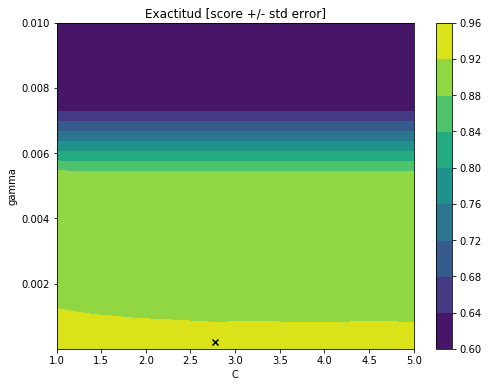

In [5]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

X, Y       = np.meshgrid(Cs,gammas)
accuracies = np.transpose(np.array(metricas_media.reshape(10,30)))

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)
cp = ax.contourf(X, Y, accuracies)
fig.colorbar(cp)
ax.set_title('Exactitud [score +/- std error]')
ax.set_xlabel('C')
ax.set_ylabel('gamma')

idx = np.argmax(accuracies)
best_C = Cs[np.int(np.floor(idx/30))]
best_gamma = gammas[np.mod(idx,30)]
plt.scatter(best_C,best_gamma, marker = 'x', color='black')

print('C:', best_C, ', gamma:', best_gamma)
plt.show()

### Generación del mejor modelo SVM usando los híper-parámetros encontrados

In [6]:
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(atributos, etiquetas, test_size=0.3, random_state=0)

mejor_modelo = SVC(C = best_C, gamma = best_gamma)
mejor_modelo.fit(X_entrenamiento,y_entrenamiento)

# Evaluación de residuos (evaluación de entrenamiento)
exactitud_entrenamiento = mejor_modelo.score(X_entrenamiento,y_entrenamiento)
print('Entrenamiento:', exactitud_entrenamiento)

# Evaluación de prueba
exactitud_prueba = mejor_modelo.score(X_prueba,y_prueba)
print('Prueba:', exactitud_prueba)

Entrenamiento: 0.9597989949748744
Prueba: 0.9649122807017544


## Optimización usando Optimización Bayesiana
Se puede utilizar el código implementado en:
https://github.com/thuijskens/bayesian-optimization